# PMR3508-2024-70

Classification of Adult Database (from Kaggle) using k-Nearest Neighbor (kNN)

This Notebook is divided in the following sections:
1. Exploratory Analysis
2. Classifier Development

First, we import the libraries that we're going to use

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

Then, we import the Adult dataset into a Pandas DataFrame.

In [49]:
df = pd.read_csv('data/train_data.csv')
df.set_index('Id', inplace=True)
print()

## 1. Exploratory Analysis

### 1.1 Data Understanding

In this subsection, we take a first look at the dataset to gain some insights of the data.


In [50]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [51]:
df.shape

(32560, 15)

Number of columns is actually 15 if we don't count the Id column, we'll set it as the index later

In [52]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

Objects type are strings that have to be processed with one-hot encoding so we can use it to train our models.

To get a quick overview of some statistics of the numerical features of our dataframe, we use the describe method.

In [53]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### 1.2 Data Preparation
- Rename columns
- Drop irrelevant columns and rows
- Identify duplicated rows

First, we rename the columns for better visualization

In [54]:
df.rename(columns={'age': 'Age',
                   'workclass': 'Workclass',
                   'fnlwgt': 'Final Weight',
                   'education': 'Education',
                   'education.num': 'Education Number',
                   'marital.status': 'Maritial Status',
                   'occupation': 'Occupation',
                   'relationship': 'Relationship',
                   'race': 'Race',
                   'sex': 'Sex',
                   'capital.gain': 'Capital Gain',
                   'capital.loss': 'Capital Loss',
                   'hours.per.week': 'Hours per Week',
                   'native.country': 'Native Country',
                   'income': 'Target'
                   }, inplace=True)
df.head()

,Age,Workclass,Final Weight,Education,Education Number,Maritial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per Week,Native Country,Target
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


Now we remove rows with missing data

In [55]:
df.replace("?", np.nan, inplace=True)

In [56]:
df.isna().sum()

Age                    0
Workclass           1836
Final Weight           0
Education              0
Education Number       0
Maritial Status        0
Occupation          1843
Relationship           0
Race                   0
Sex                    0
Capital Gain           0
Capital Loss           0
Hours per Week         0
Native Country       583
Target                 0
dtype: int64

In [57]:
df = df.dropna()
df.shape

(30161, 15)

Now we identify duplicated rows

In [58]:
df.duplicated().sum()

23

Each row represents a person and it is possible that two people have the same census data, however this is unlikely to happen. So we'll choose to exclude this duplicated data.

In [59]:
df.drop_duplicates(inplace=True)
df.duplicated().sum() # to verify if duplicated values were excluded

0

Now, do the same to the test dataset

In [60]:
df_test = pd.read_csv('data/test_data.csv')
df_test.set_index('Id', inplace=True)
df_test.rename(columns={'age': 'Age',
                   'workclass': 'Workclass',
                   'fnlwgt': 'Final Weight',
                   'education': 'Education',
                   'education.num': 'Education Number',
                   'marital.status': 'Maritial Status',
                   'occupation': 'Occupation',
                   'relationship': 'Relationship',
                   'race': 'Race',
                   'sex': 'Sex',
                   'capital.gain': 'Capital Gain',
                   'capital.loss': 'Capital Loss',
                   'hours.per.week': 'Hours per Week',
                   'native.country': 'Native Country',
                   'income': 'Target'
                   }, inplace=True)
df_test.replace("?", np.nan, inplace=True)
df_test = df_test.dropna()
df_test.drop_duplicates(inplace=True)

In [76]:
df_test.head()

,Age,Workclass,Final Weight,Education,Education Number,Maritial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per Week,Native Country
Id,,,,,,,,,,,,,,
0,25,Private,120596,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,44,United-States
1,64,State-gov,152537,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
2,31,Private,100135,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
3,45,Private,189123,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States
4,64,Self-emp-inc,487751,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States


In [61]:
print(df.isna().sum()) #to verify if na values were excluded
print(df.duplicated().sum()) #to verify if duplicated values were excluded

Age                 0
Workclass           0
Final Weight        0
Education           0
Education Number    0
Maritial Status     0
Occupation          0
Relationship        0
Race                0
Sex                 0
Capital Gain        0
Capital Loss        0
Hours per Week      0
Native Country      0
Target              0
dtype: int64
0


### 1.3 Feature Understanding

Plot of features distributions to gain more insights. We'll start with personal-related features.

In [62]:
df.head()

,Age,Workclass,Final Weight,Education,Education Number,Maritial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per Week,Native Country,Target
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


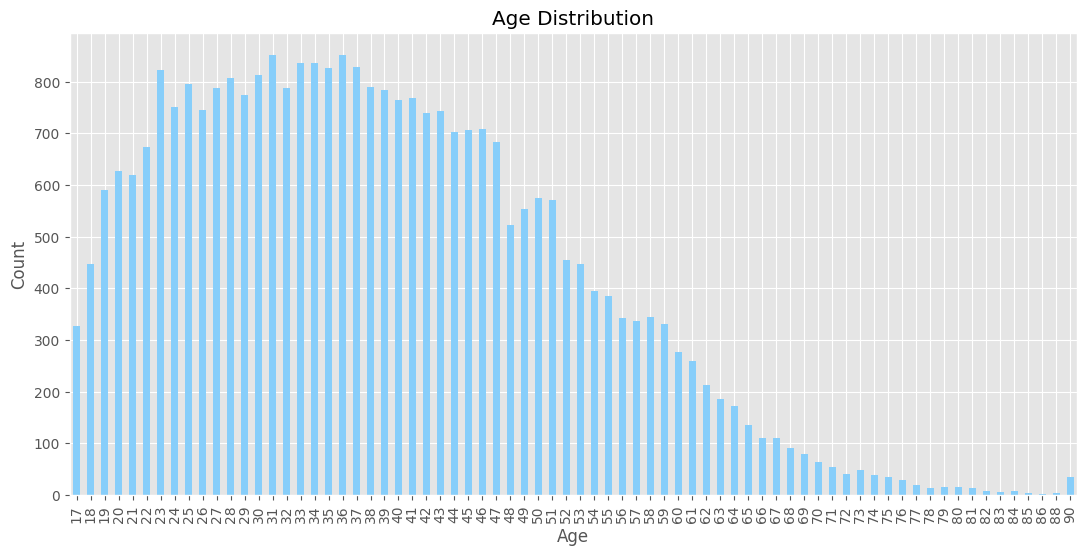

In [63]:
# Feature: Age
plt.figure(figsize=(13,6)) 
df['Age'].value_counts().sort_index().plot(kind='bar', color=['lightskyblue'])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [64]:
df['Native Country'].value_counts()

Native Country
United-States                 27486
Mexico                          606
Philippines                     188
Germany                         128
Puerto-Rico                     109
Canada                          107
El-Salvador                     100
India                           100
Cuba                             92
England                          86
Jamaica                          80
South                            71
China                            68
Italy                            68
Dominican-Republic               67
Vietnam                          64
Guatemala                        61
Japan                            59
Poland                           56
Columbia                         56
Iran                             42
Haiti                            42
Taiwan                           42
Portugal                         34
Nicaragua                        33
Peru                             30
Greece                           29
Ecuador      

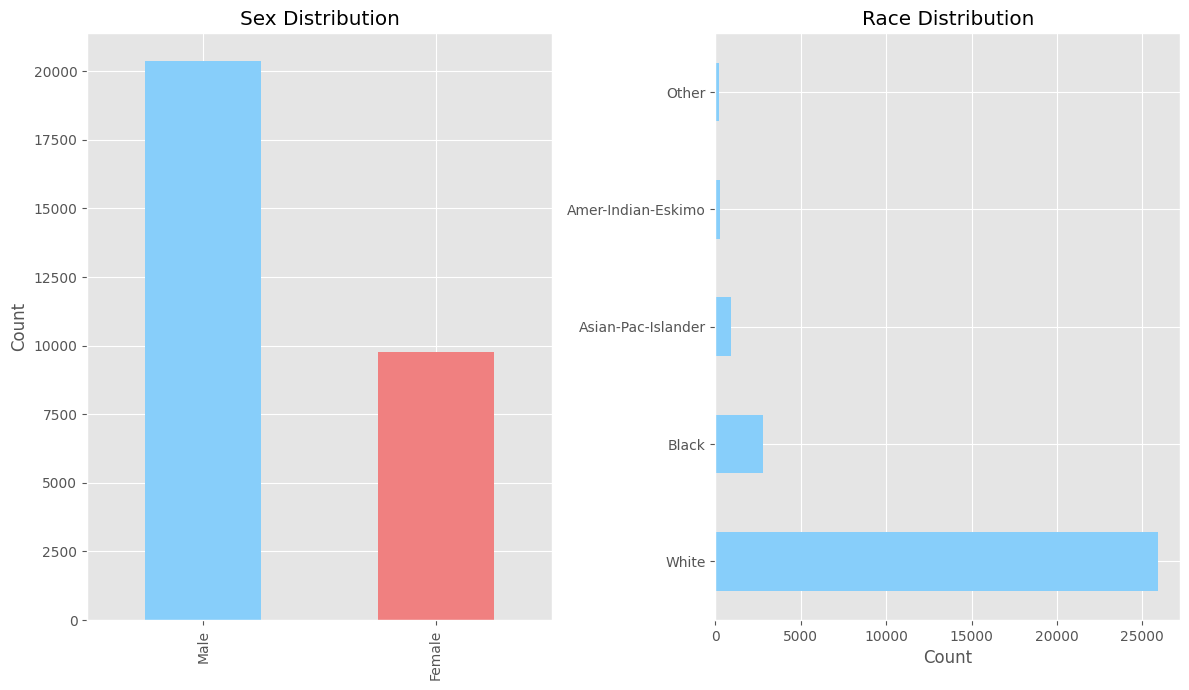

In [65]:
# Features: Sex and Race
sex_list = df['Sex'].value_counts()
race_list = df['Race'].value_counts()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 7))

# First subplot
sex_list.plot(kind='bar', ax=ax1, color=['lightskyblue', 'lightcoral'])
ax1.set_title('Sex Distribution')
ax1.set_ylabel('Count')
ax1.set_xlabel('')

# Second subplot
race_list.plot(kind='barh', ax=ax2, color='lightskyblue')
ax2.set_title('Race Distribution')
ax2.set_ylabel('')
ax2.set_xlabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

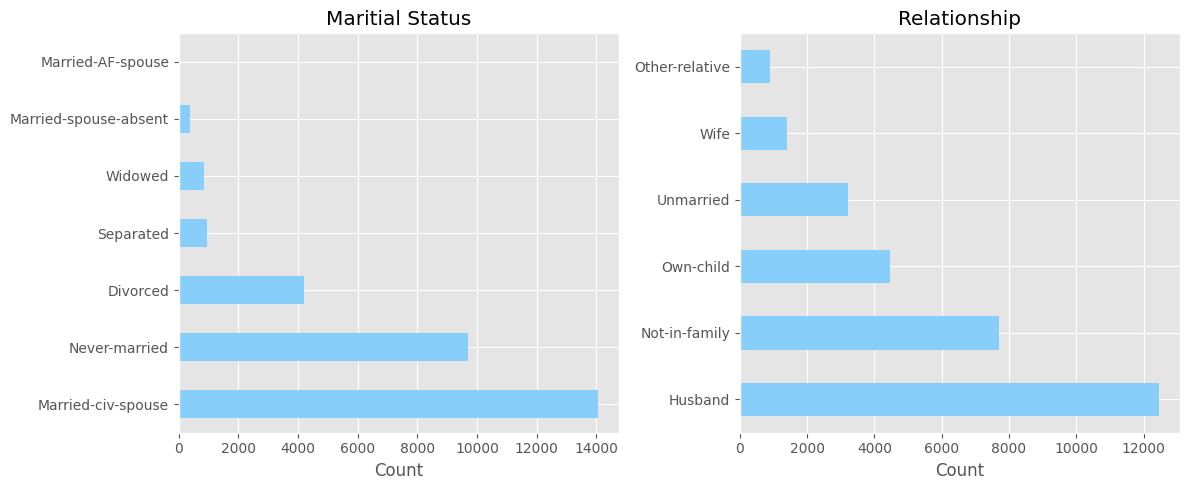

In [66]:
# Features: Maritial Status and Relationship
status_list = df['Maritial Status'].value_counts()
relationship_list = df['Relationship'].value_counts()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# First subplot
status_list.plot(kind='barh', ax=ax1, color=['lightskyblue'])
ax1.set_title('Maritial Status')
ax1.set_ylabel('')
ax1.set_xlabel('Count')

# Second subplot
relationship_list.plot(kind='barh', ax=ax2, color='lightskyblue')
ax2.set_title('Relationship')
ax2.set_ylabel('')
ax2.set_xlabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

### 1.4 Features Relationship

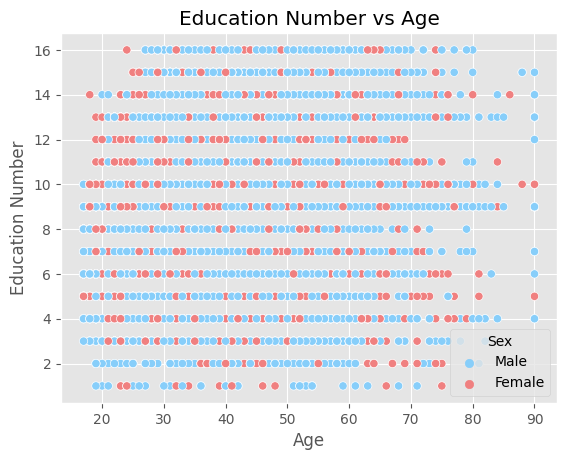

In [67]:
sns.scatterplot(
        x='Age',
        y='Education Number',
        hue='Sex',
        palette=['lightskyblue', 'lightcoral'],
        data=df)
plt.title('Education Number vs Age')
plt.show()

In [68]:
df.columns

Index(['Age', 'Workclass', 'Final Weight', 'Education', 'Education Number',
       'Maritial Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours per Week', 'Native Country',
       'Target'],
      dtype='object')

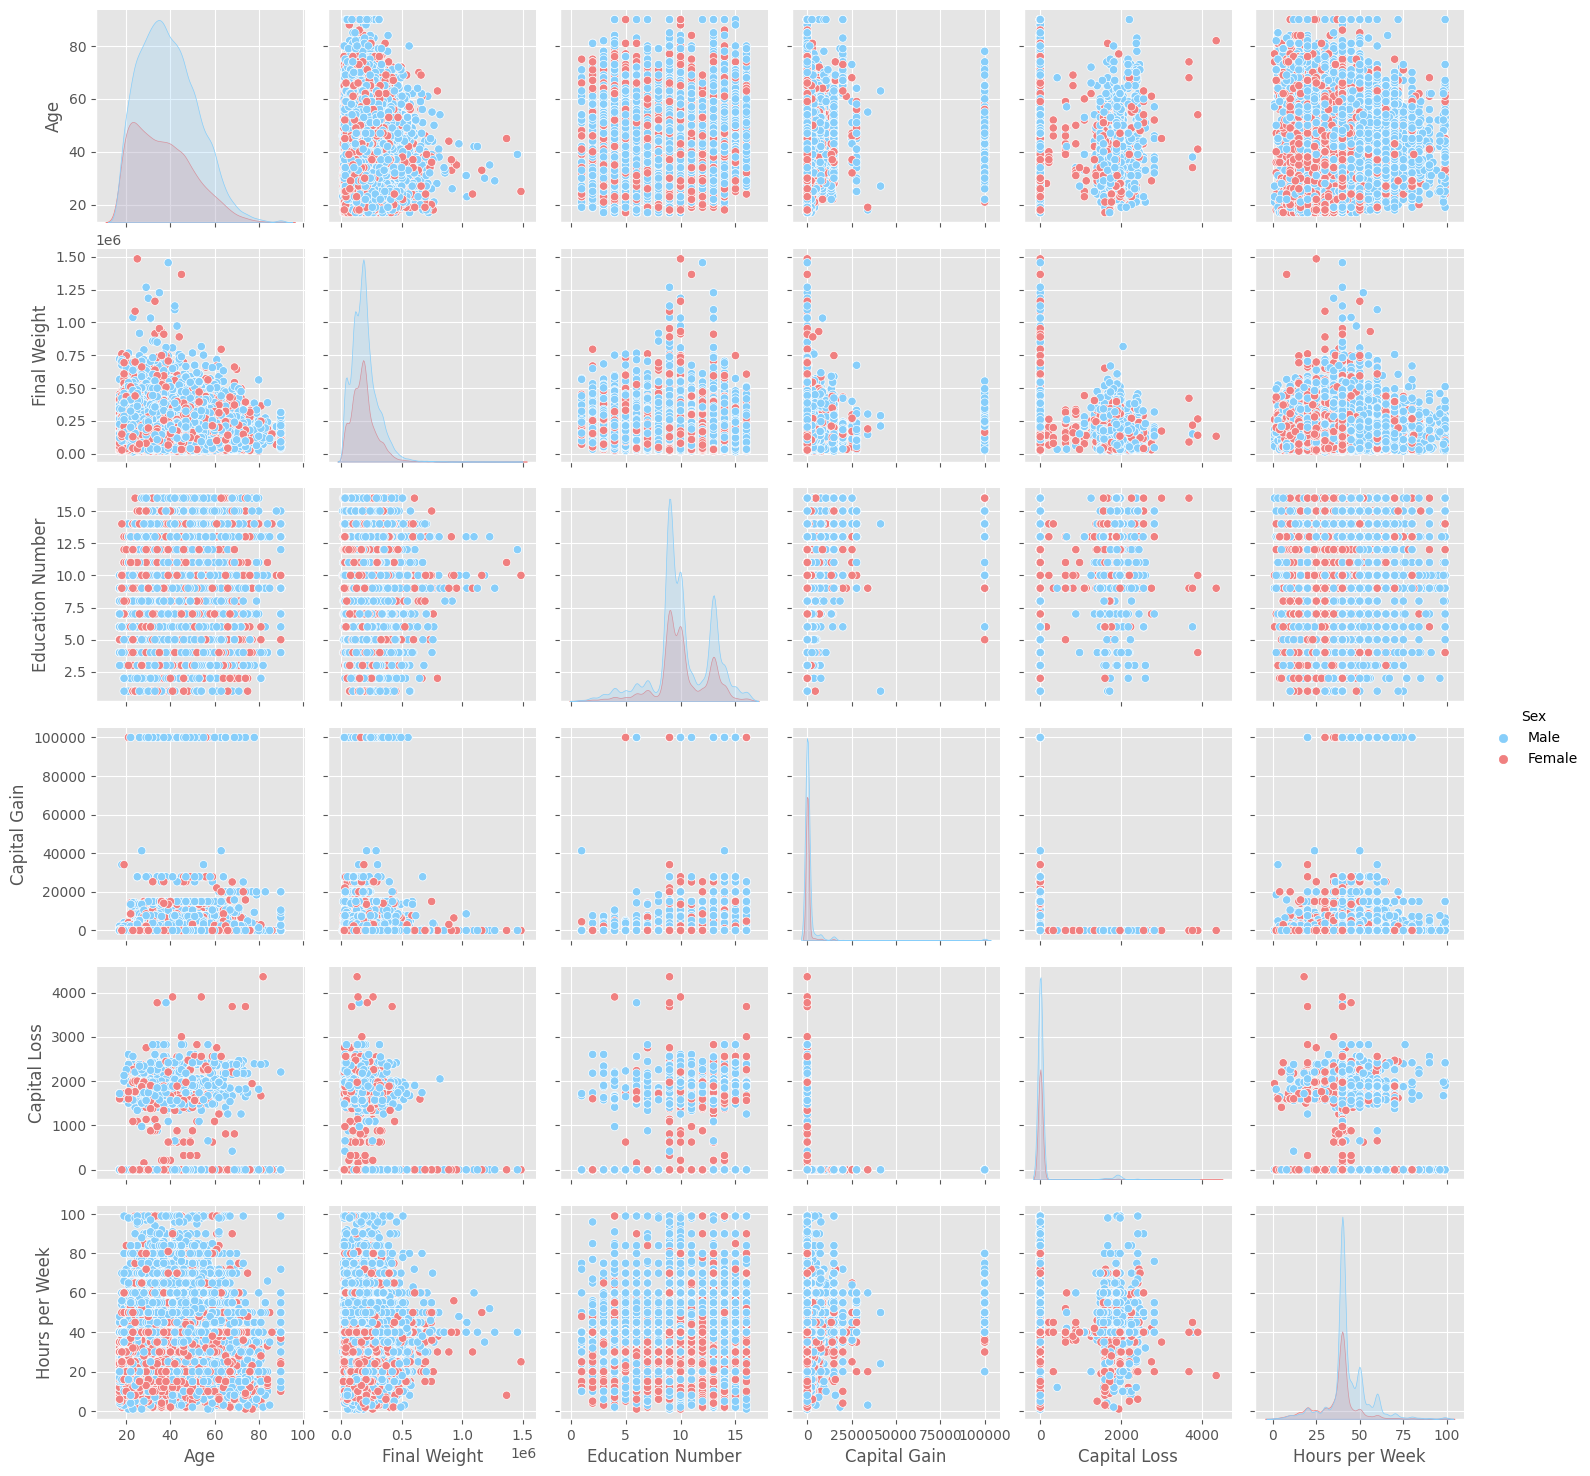

In [69]:
# Pairplot of Numerical Values
sns.pairplot(df, vars=['Age', 'Final Weight', 'Education Number',
       'Capital Gain', 'Capital Loss', 'Hours per Week'],
       hue='Sex',
       palette=['lightskyblue', 'lightcoral'])
plt.show()

In [70]:
df_corr = df[['Age', 'Final Weight','Education Number', 'Capital Gain', 'Capital Loss', 'Hours per Week']].corr()
df_corr

,Age,Final Weight,Education Number,Capital Gain,Capital Loss,Hours per Week
Age,1.000000,-0.076279,0.043202,0.080162,0.060141,0.101349
Final Weight,-0.076279,1.000000,-0.045161,0.000425,-0.009763,-0.023037
Education Number,0.043202,-0.045161,1.000000,0.124452,0.079623,0.152848
Capital Gain,0.080162,0.000425,0.124452,1.000000,-0.032254,0.080429
Capital Loss,0.060141,-0.009763,0.079623,-0.032254,1.000000,0.052380
Hours per Week,0.101349,-0.023037,0.152848,0.080429,0.052380,1.000000


<Axes: >

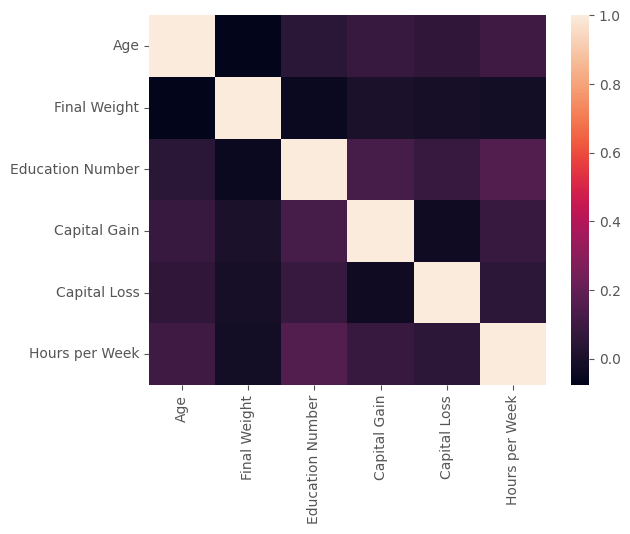

In [71]:
sns.heatmap(df_corr)

### 2. Classifier

Our dataset has both numerical and categorical features. 

We'll have to transform categorical into numerical ones, however, for nominal categories (non-ordered), LabelEnconder method may create relationship between the transformed numerical values. So one-hot encoding seems to be a better approach as it doesn't consider ordinal relationships, but it can increase dimensionality as it creates one column for each category of a feature and assign a binary value. 

So we'll start training and testing our kNN classifier only with the numerical features. After that, we'll consider the categorical ones.

### 2.1 Numerical Features



In [72]:
df.head()

,Age,Workclass,Final Weight,Education,Education Number,Maritial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per Week,Native Country,Target
Id,,,,,,,,,,,,,,,
16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K


In [36]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

In [75]:
print(df.columns)
print(df_test.columns)


Index(['Age', 'Workclass', 'Final Weight', 'Education', 'Education Number',
       'Maritial Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours per Week', 'Native Country',
       'Target'],
      dtype='object')
Index(['Age', 'Workclass', 'Final Weight', 'Education', 'Education Number',
       'Maritial Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours per Week', 'Native Country'],
      dtype='object')


In [74]:
# Train Dataset
X = df[['Age','Final Weight', 'Education Number', 'Capital Gain', 'Capital Loss', 'Hours per Week']]
Y = df.Target

# Test Dataset
X_test = df_test[['Age','Final Weight', 'Education Number', 'Capital Gain', 'Capital Loss', 'Hours per Week']]
Y_test = df_test.Target

AttributeError: 'DataFrame' object has no attribute 'Target'

X = 
Y = 
